In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


#### Importing libraries

In [2]:
import missingno as msn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding = 'latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Exploratory Data Analysis

## Statistical overview

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data types

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
# as we have datetime data, lets cast it to datetime type

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Null values

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<Axes: >

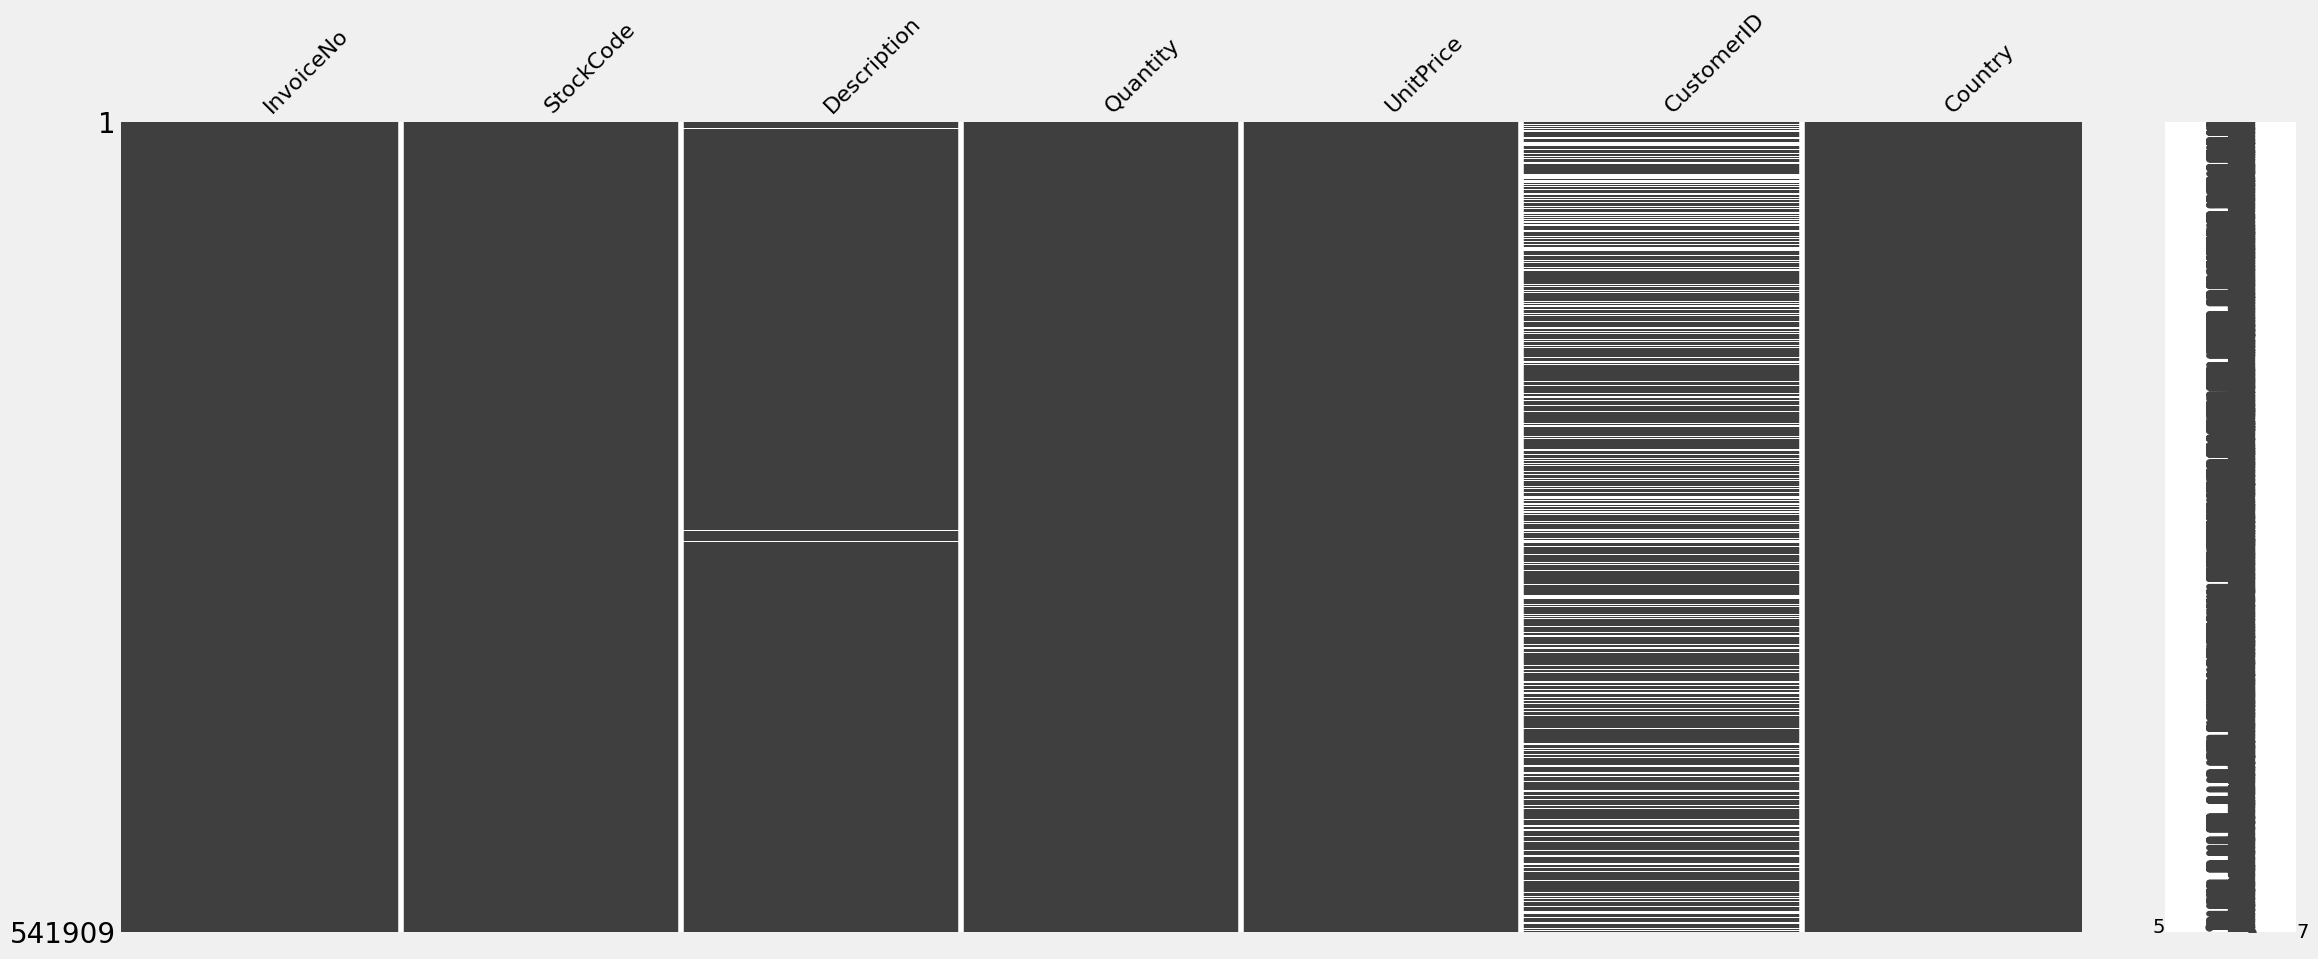

In [8]:
# visualizing dataset to see the null values
msn.matrix(df)

In [9]:
# dropping CustomerID column as it has too many null values
df = df.drop(columns=['CustomerID'])


In [10]:
# lets see the description column which says have null value
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


In [11]:
# lets impute these with  UNKNOWN ITEMS as the unit price is also 0
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

## Checking all columns

In [12]:
df['Description'].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

Text(0.5, 1.0, 'Which item were bought more often ?')

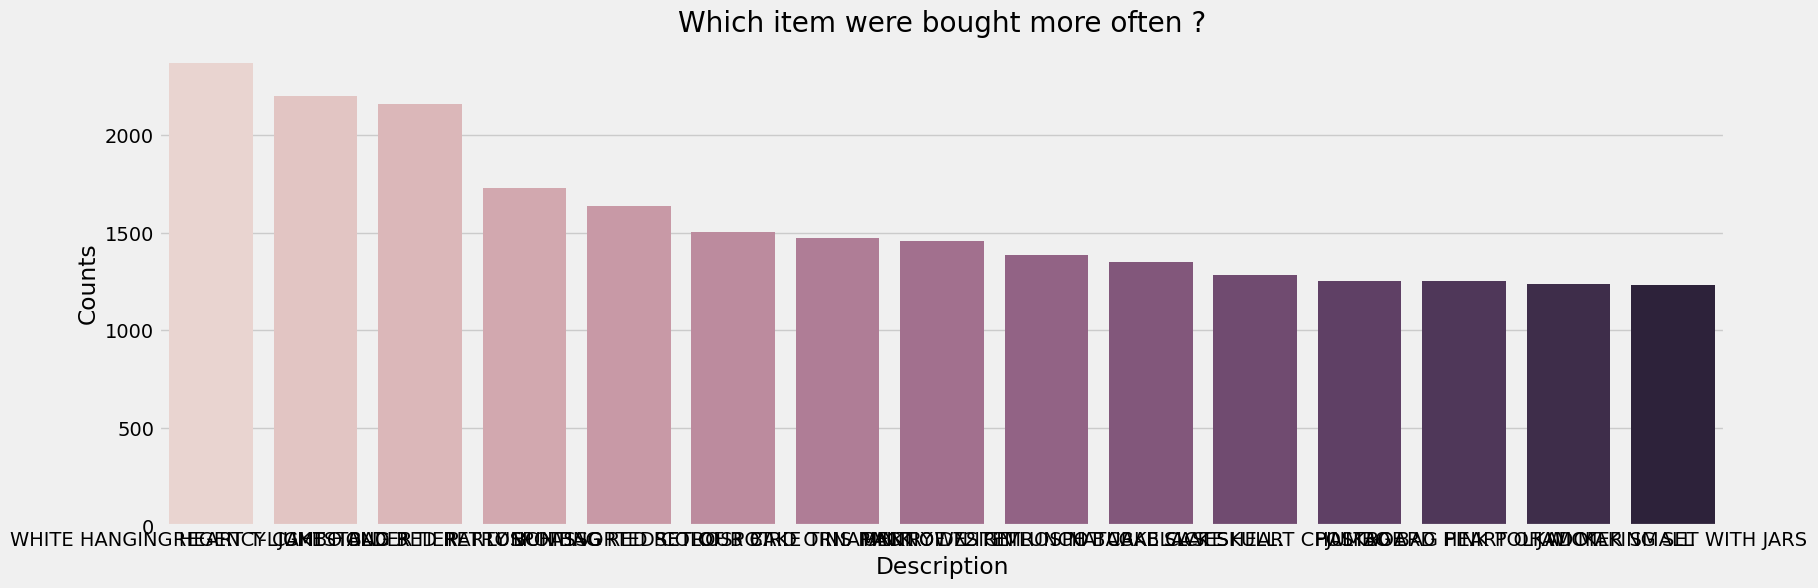

In [13]:
item_counts = df['Description'].value_counts().sort_values(ascending = False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x = item_counts.index, y = item_counts.values,  palette = sns.cubehelix_palette(15))
plt.ylabel('Counts')
plt.title('Which item were bought more often ?')
# plt.xticks(rotation = 90)

In [14]:
df['Description'].value_counts().tail()

Description
Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: count, dtype: int64

In [15]:
# We can valid items are normally upper case and non-valid are in lower case
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Description
Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: count, dtype: int64

Text(0.5, 1.0, 'Not full uppercase items')

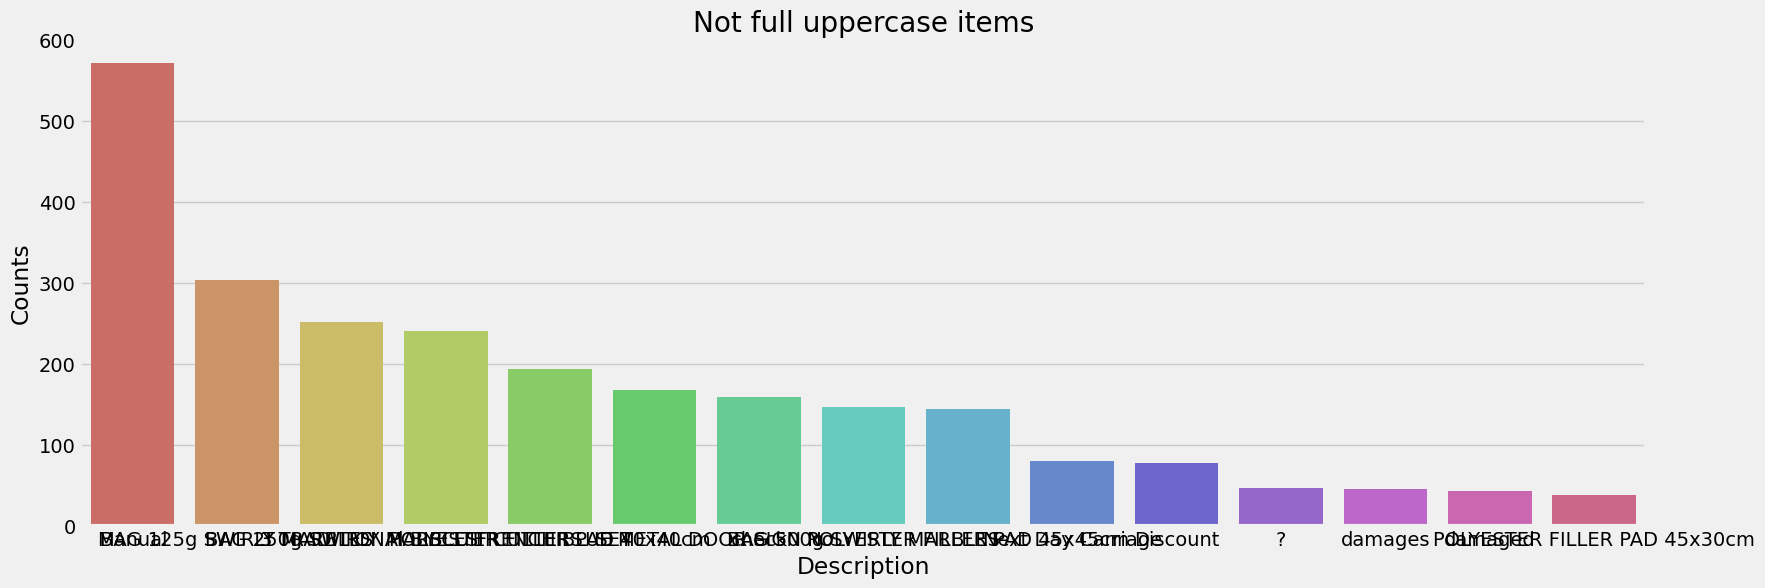

In [16]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x = lcase_counts.index, y = lcase_counts.values, palette = sns.color_palette('hls', 15))
plt.ylabel('Counts')
plt.title('Not full uppercase items')
# plt.xticks()

In [17]:
# checking StockCode 
df['StockCode'].value_counts().head()

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '85123A'),
  Text(1, 0, '22423'),
  Text(2, 0, '85099B'),
  Text(3, 0, '47566'),
  Text(4, 0, '20725'),
  Text(5, 0, '84879'),
  Text(6, 0, '22720'),
  Text(7, 0, '22197'),
  Text(8, 0, '21212'),
  Text(9, 0, '20727'),
  Text(10, 0, '22383'),
  Text(11, 0, '22457'),
  Text(12, 0, '23203'),
  Text(13, 0, 'POST'),
  Text(14, 0, '22386')])

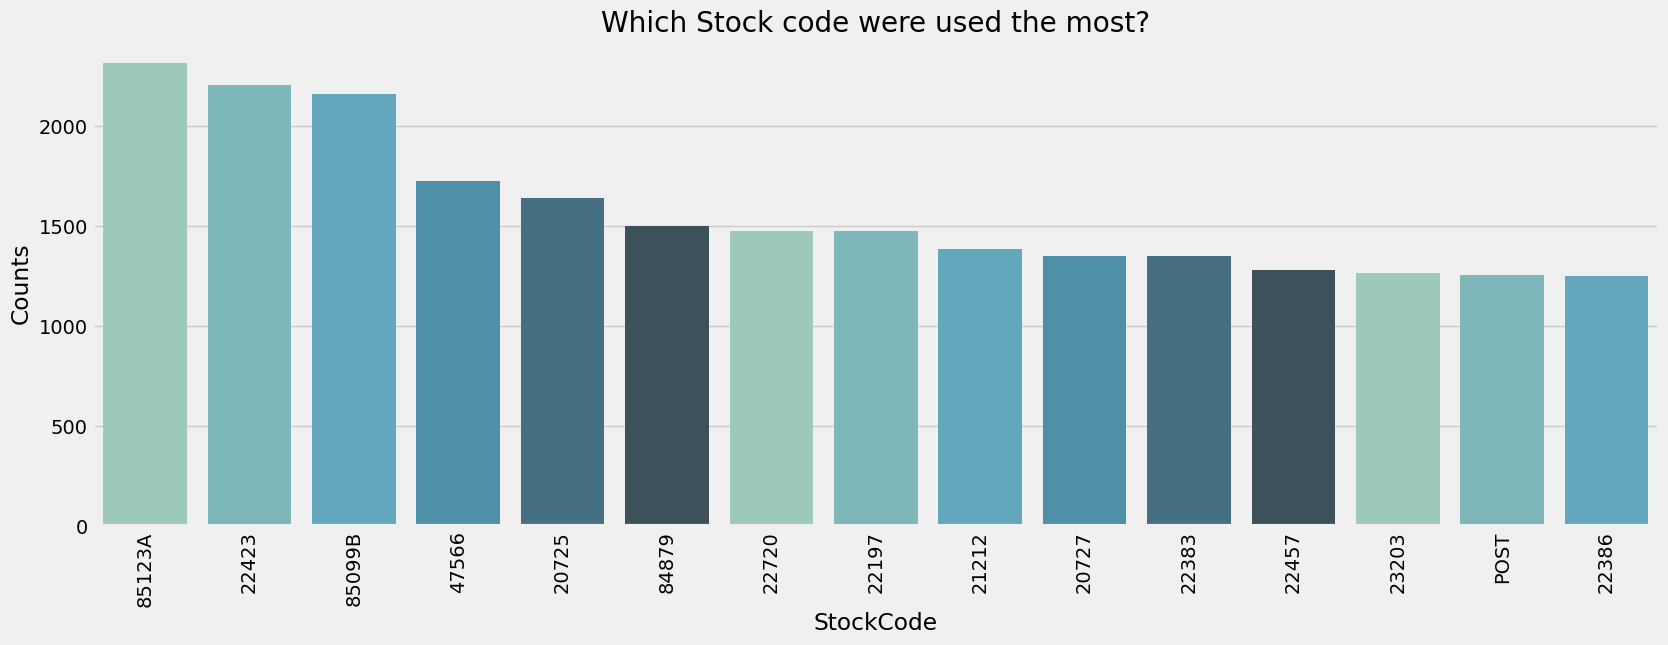

In [18]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending = False).iloc[0:15]

plt.figure(figsize=(18, 6))
sns.barplot(x = stock_counts.index, y = stock_counts.values, palette = sns.color_palette('GnBu_d'))
plt.ylabel('Counts')
plt.title('Which Stock code were used the most?')
plt.xticks(rotation=90)

In [19]:
# Checking the Invoice number
df['InvoiceNo'].value_counts().tail()

InvoiceNo
554023     1
554022     1
554021     1
554020     1
C558901    1
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '573585'),
  Text(1, 0, '581219'),
  Text(2, 0, '581492'),
  Text(3, 0, '580729'),
  Text(4, 0, '558475'),
  Text(5, 0, '579777'),
  Text(6, 0, '581217'),
  Text(7, 0, '537434'),
  Text(8, 0, '580730'),
  Text(9, 0, '538071'),
  Text(10, 0, '580367'),
  Text(11, 0, '580115'),
  Text(12, 0, '581439'),
  Text(13, 0, '580983'),
  Text(14, 0, '578344')])

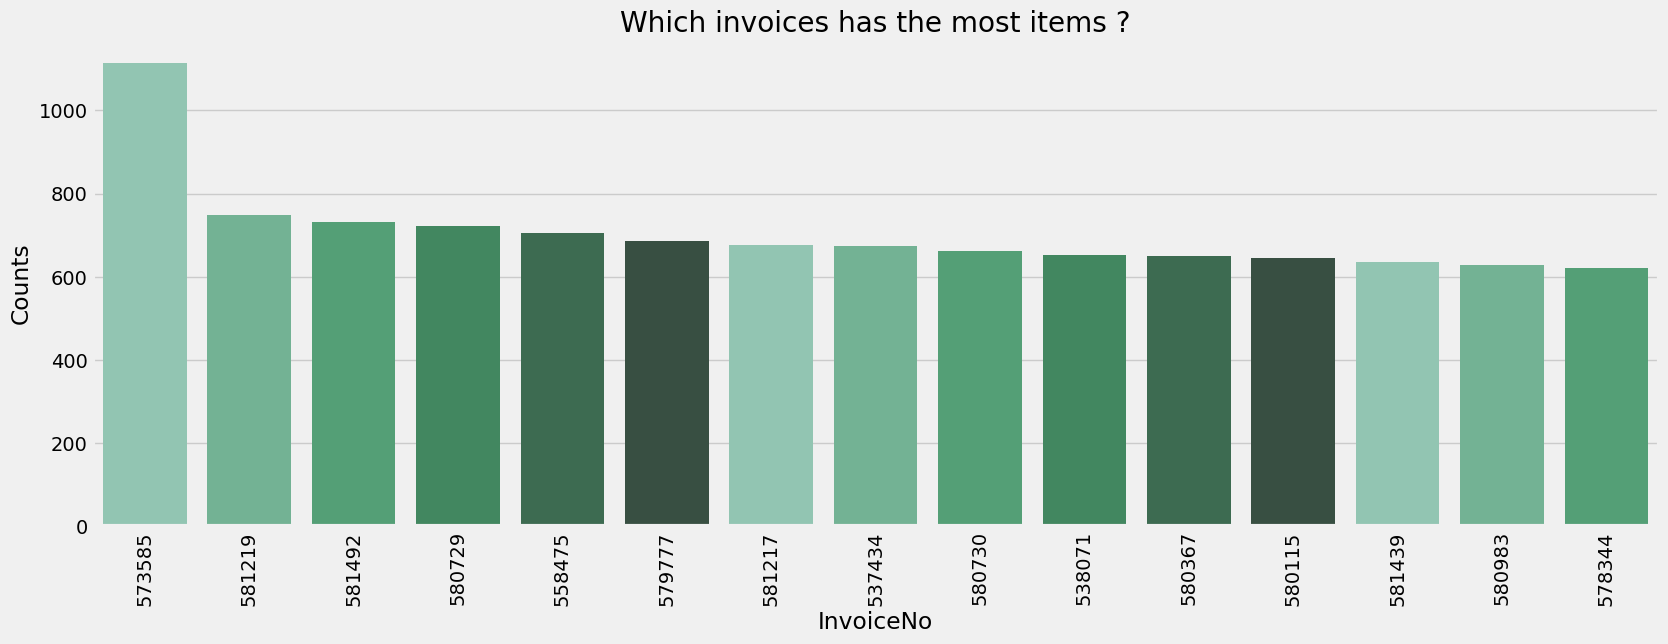

In [20]:
invoice_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]

plt.figure(figsize = (18, 6))
sns.barplot(x = invoice_counts.index, y = invoice_counts.values, palette = sns.color_palette('BuGn_d'))
plt.ylabel('Counts')
plt.title("Which invoices has the most items ?")
plt.xticks(rotation = 90)

In [21]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


In [22]:
# Looks like invoices that start with C are the cancelling a / Returning invoices, which tells us about the negative values

df = df[~df['InvoiceNo'].str.startswith('C')]

df.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


In [23]:
# lets explore more as we still see negative values

df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


In [24]:
# as we see these neagative values are for unknown items

df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


In [25]:
# lets check unit price now
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [26]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


In [27]:
# lets ignore these for now
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


As the data is cleaned now, lets add some features init

In [28]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


# Visualization

(array([0]), [Text(0, 0, 'United Kingdom')])

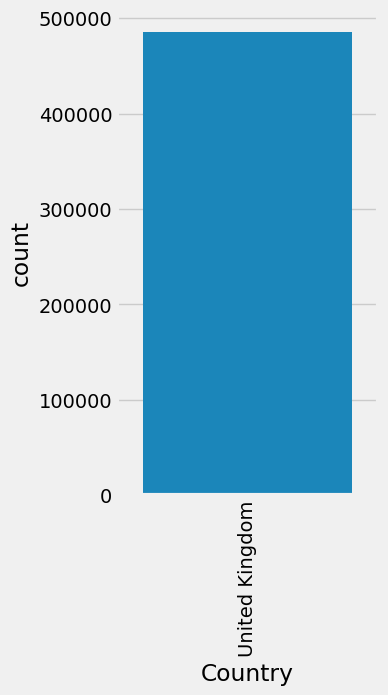

In [29]:
plt.figure(figsize=(3, 6))
sns.countplot(x = df[df['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

<Axes: xlabel='Country', ylabel='count'>

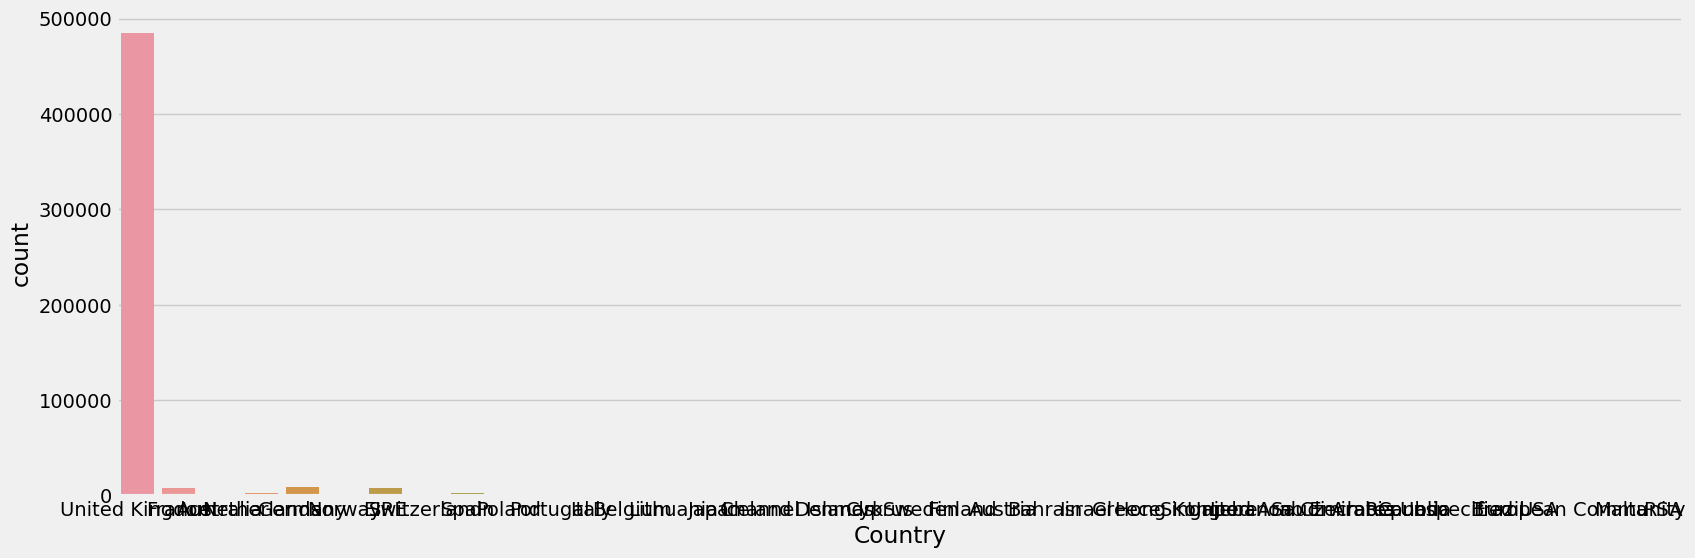

In [30]:
plt.figure(figsize=(18, 6))
sns.countplot(x = df[df['Country'] != 'Unite Kingdom']['Country'])
# plt.xticks(rotation = 90)

In [31]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count / all_count
print(str('{0:.2f}%').format(uk_perc * 100))

91.51%


## Detecting Outliers

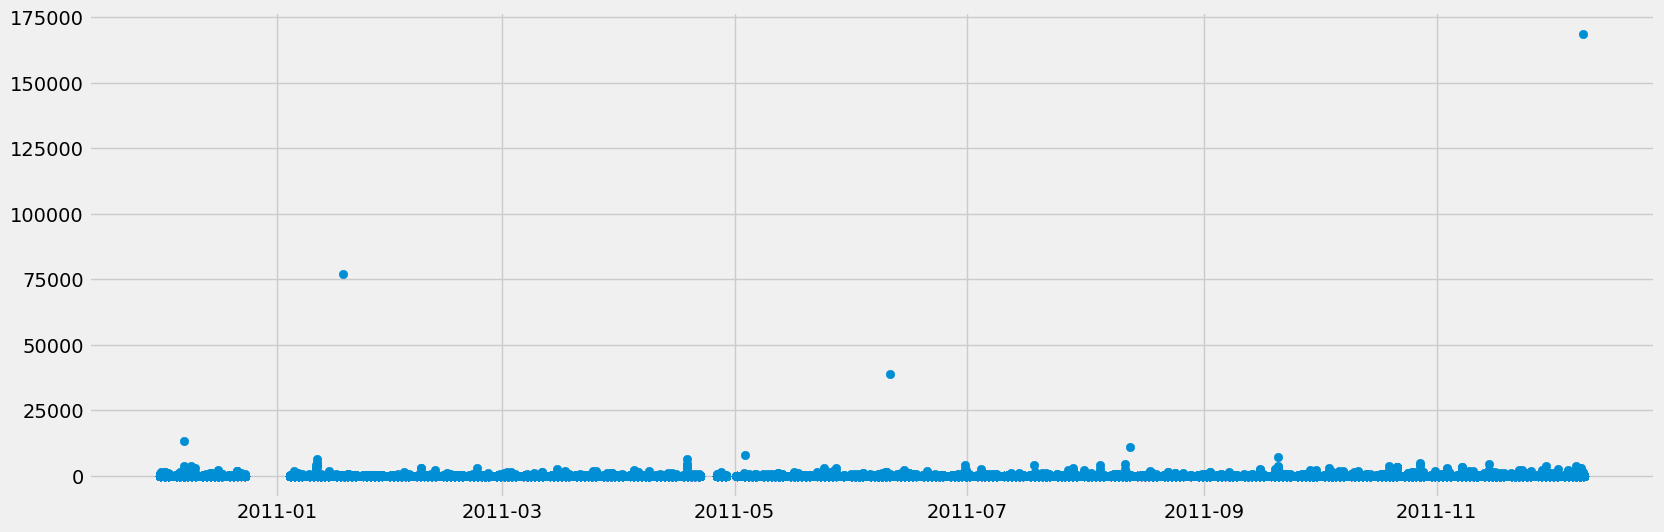

In [32]:
plt.figure(figsize=(18, 6))
plt.scatter(x = df.index, y = df['Sales'])

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

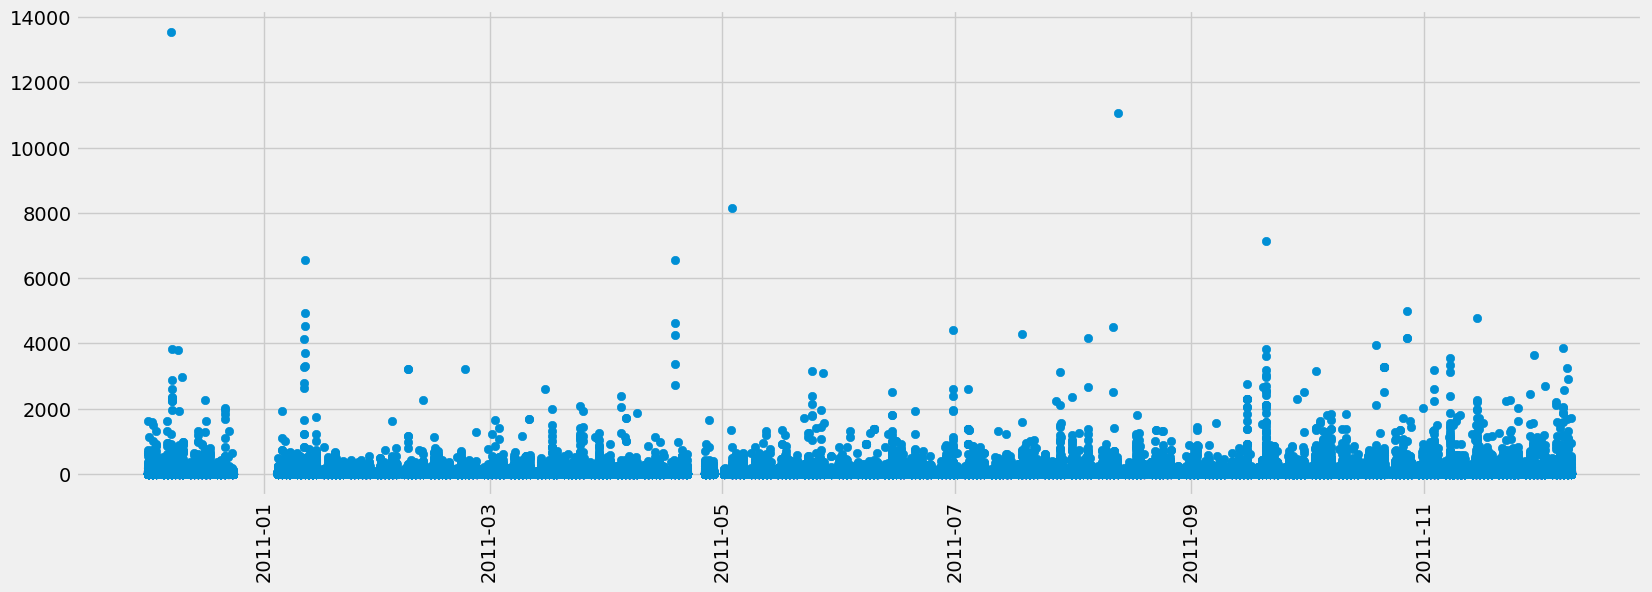

In [33]:
# lets remove the outliers as seen in above plot
df = df[df['Sales'] < 25000]
plt.figure(figsize = (18, 6))
plt.scatter(x = df.index, y = df['Sales'])
plt.xticks(rotation=90)

In [34]:
# we can see values that are out of normal destribution

df.quantile([0.05, 0.95, 0.98, 0.99, 0.999], numeric_only = True)

,Quantity,UnitPrice,Sales
0.050,1.0,0.42,1.25
0.950,30.0,9.95,59.70
0.980,72.0,14.95,121.68
0.990,100.0,16.98,183.60
0.999,446.4,165.00,833.79


(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

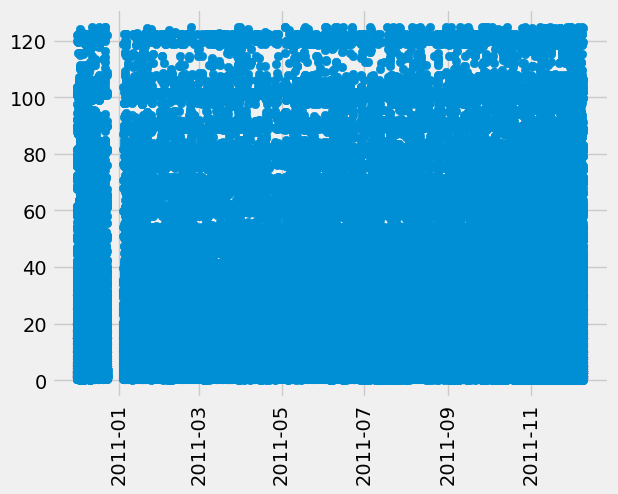

In [35]:
# this gives us that if we remove top 2% of data we will get rid of absolute outliers

df_quantile = df[df['Sales']  < 125]
plt.scatter(x = df_quantile.index, y = df_quantile['Sales'])
plt.xticks(rotation = 90)

In [36]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,519958.000000,519958.000000,519958.000000
mean,7.850934,3.286582,13.850263
std,15.303867,3.949021,16.330954
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.220000
max,1600.000000,124.870000,124.950000


# Distribution of numeric features

<Axes: ylabel='Density'>

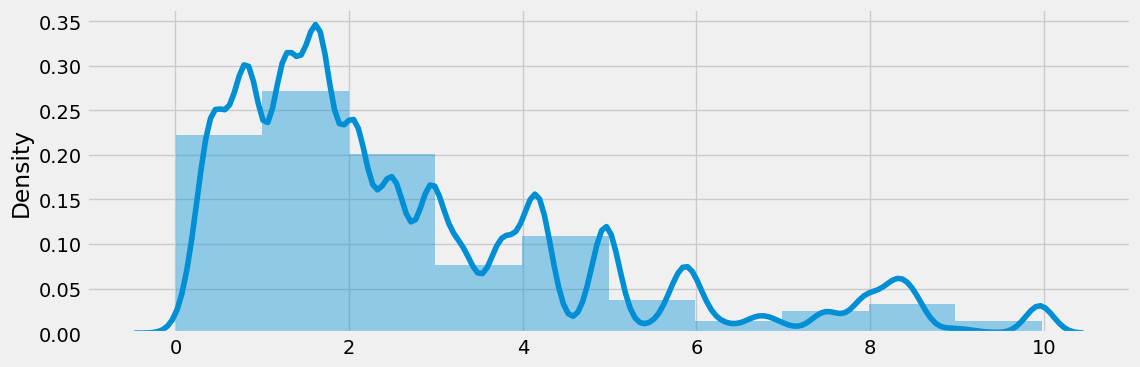

In [37]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

<Axes: ylabel='Density'>

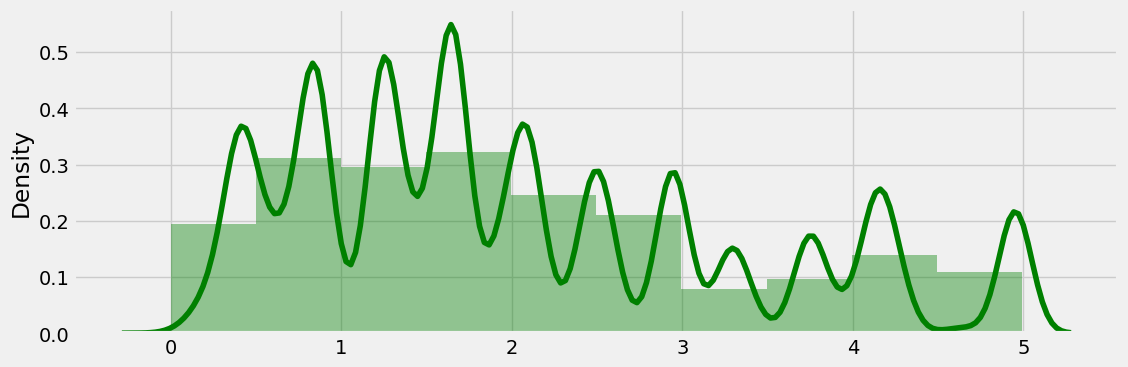

In [38]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color = 'green')

<Axes: ylabel='Density'>

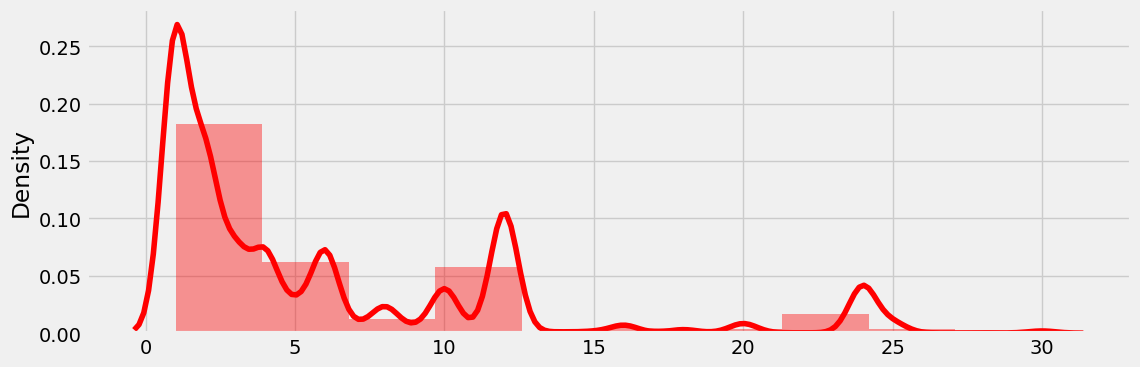

In [39]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'].values, kde=True, bins=10, color = 'red')

<Axes: ylabel='Density'>

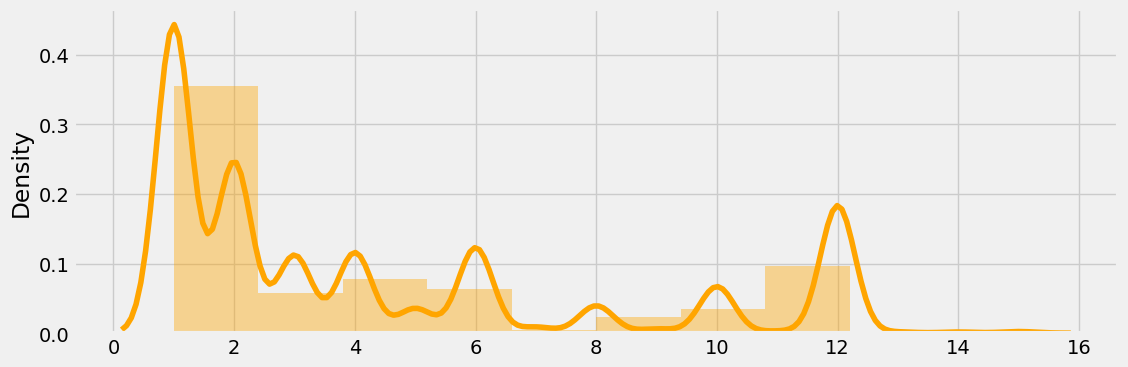

In [40]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'].values, kde=True, bins=10, color = 'orange')

from these histograms we can say people normally bought 1-5 items or 10-12 maybe.

<Axes: ylabel='Density'>

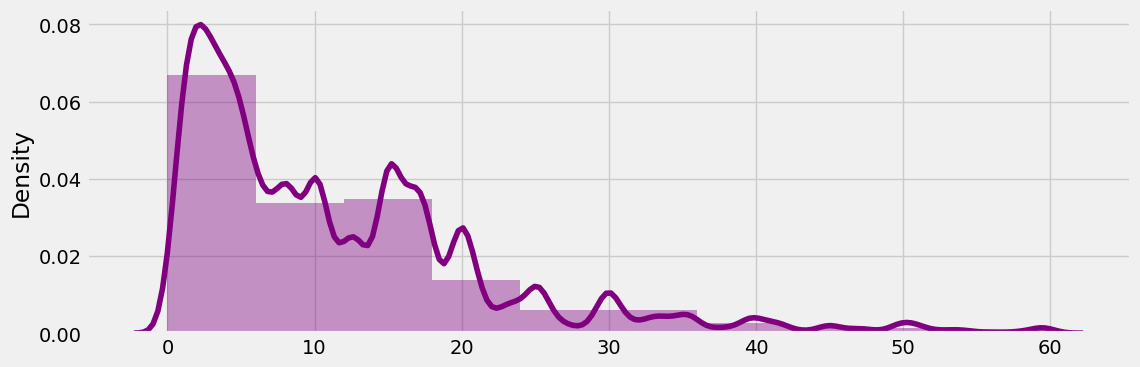

In [41]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'].values, kde=True, bins=10, color = 'purple')

<Axes: ylabel='Density'>

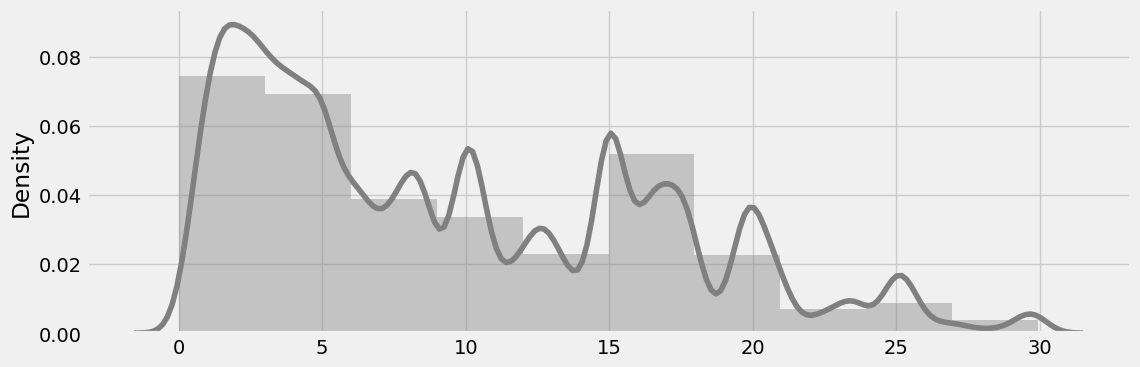

In [42]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'].values, kde=True, bins=10, color = 'grey')

from these histogram we cab sae majority sales per order were in range 1-15 pounds each

## Sales over time

In [43]:
df_ts = df[['Sales']]
df_ts.head()

,Sales
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


<Axes: xlabel='InvoiceDate'>

<Figure size 1800x600 with 0 Axes>

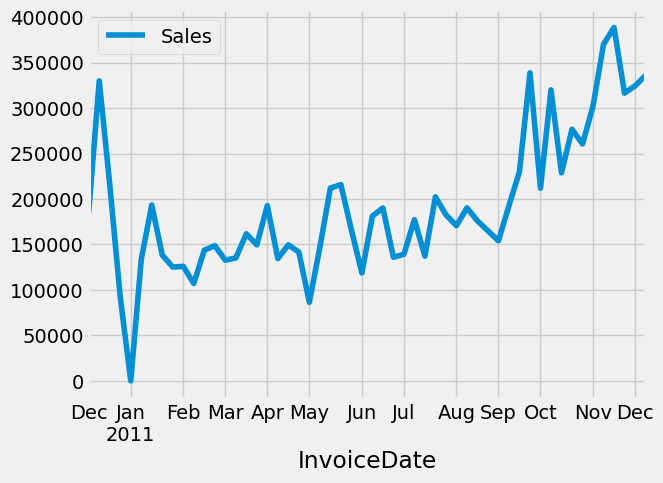

In [44]:
# lets resample data to see if there is any pattern

plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

In [45]:
# lets check that Jan with 0 sales

df_resample['12-2010':'01-2011']

,Sales
InvoiceDate,
2010-12-05,185427.83
2010-12-12,329936.81
2010-12-19,216012.20
2010-12-26,92369.30
2011-01-02,0.00
2011-01-09,133658.19
2011-01-16,193362.04
2011-01-23,138349.58
2011-01-30,125170.79


probably there was a New year holiday

# Preparing data for modeling and feature creation

In [46]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice,Sales
count,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870
std,38.123726,2.669829,64.710055
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,4800.000000,14.960000,7144.720000


In [47]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=520393, freq=None)

## Quantity per invoice feature

In [48]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [49]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how = 'left', on = 'InvoiceNo')
df_clean = df_clean.rename(columns = {
    'Quantity_x': 'Quantity',
    'Quantity_y': 'QuantityInv'
})
df_clean.tail(14)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv
520379,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,19.80,2011-12-09 12:50:00,105
520380,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,19.80,2011-12-09 12:50:00,105
520381,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,15.00,2011-12-09 12:50:00,105
520382,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,15.00,2011-12-09 12:50:00,105
520383,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,15.00,2011-12-09 12:50:00,105
520384,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,15.00,2011-12-09 12:50:00,105
520385,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,15.60,2011-12-09 12:50:00,105
520386,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520387,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,16.60,2011-12-09 12:50:00,105
520388,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,10.20,2011-12-09 12:50:00,105


In [50]:
df_clean.describe()

,Quantity,UnitPrice,Sales,InvoiceDate,QuantityInv
count,520393.000000,520393.000000,520393.000000,520393,520393.000000
mean,10.409364,2.978735,18.669870,2011-07-05 01:44:18.499941632,533.328732
min,1.000000,0.001000,0.001000,2010-12-01 08:26:00,1.000000
25%,1.000000,1.250000,3.750000,2011-03-28 13:28:00,152.000000
50%,4.000000,2.080000,9.840000,2011-07-20 16:12:00,300.000000
75%,12.000000,4.130000,17.400000,2011-10-19 13:58:00,567.000000
max,4800.000000,14.960000,7144.720000,2011-12-09 12:50:00,15049.000000
std,38.123726,2.669829,64.710055,NaN,890.339855


In [51]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

## Bucketizing Quantity and UnitPrice feature

In [52]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins = bins_q)

bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins = bins_p)

df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


## Extracting and bucketSizing dates

In [53]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [54]:
bins_d = pd.IntervalIndex.from_tuples([(0, 3), (3, 6), (6, 9), (9, 12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins = bins_d, labels = ['q1', 'q2' , 'q3', 'q4'])
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


# Building a model

## Splitting data

In [55]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


## Extracting features and creating dummy variables

In [56]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]
df_uk_model.head()

,Sales,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


In [57]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix = 'qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix = 'pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix = 'dr')
df_data.head()

,Sales,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
1,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,22.00,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
3,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
4,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True


## Scalling

In [58]:
# as majority of our features are in 0-1 range , lets scale QuantityInv
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

## Train-test Split

In [59]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Testing and validating different models

In [60]:
# Linear Regression
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()


# Decision Tree
min_tree_splits = range(2, 3)
min_tree_leaves = range(2, 3)
param_grid_tree = dict(min_samples_split = min_tree_splits,
                      min_samples_leaf = min_tree_leaves)
tree_model = DecisionTreeRegressor()


# Random Forest
estimators_space = [100]
min_sample_splits = range(2, 4)
min_sample_leaves = range(2, 3)
param_grid_forest = dict(min_samples_split = min_sample_splits,
                        min_samples_leaf=min_tree_leaves,
                        n_estimators=estimators_space)
forest_model = RandomForestRegressor()


cv = 5

models_to_test = ['LinearRegression','DecisionTreeRegressor','RandomForest']

regression_dict = dict(
    LinearRegression = linear_model,
    DecisionTreeRegressor = tree_model,
    RandomForest = forest_model
)

param_grid_dict = dict(
    LinearRegression = param_grid_linear,
    DecisionTreeRegressor = param_grid_tree,
    RandomForest = param_grid_forest
)

score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}


for model in models_to_test:
    regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv = cv, n_jobs = -1)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    print("===== Start report for regressor {} ===".format(model))
    score_dict[model] = regressor.best_score_
    print("Tuned Parameters : {}".format(regressor.best_params_))
    params_dict[model] = regressor.best_params_
    print("Best Score is {}".format(regressor.best_score_))
    
    mae_dict[model] = mean_absolute_error(y_test, y_pred)
    print("MAE for {}".format(model))
    print(mean_absolute_error(y_test, y_pred))
    mse_dict[model] = mean_squared_error(y_test, y_pred)
    print("MSE for {}".format(model))
    print(mean_squared_error(y_test, y_pred))
    r2_dict[model] = r2_score(y_test, y_pred)
    print("R2 SCore for {}".format(model))
    print(r2_score(y_test, y_pred))
    
    print("==== End of Report for model {} ==== ".format(model))
    
    print()
    best_est_dict[model] = regressor.best_estimator_

===== Start report for regressor LinearRegression ===
Tuned Parameters : {'fit_intercept': False}
Best Score is 0.17424255885251666
MAE for LinearRegression
15.091773552991555
MSE for LinearRegression
3918.9781366892084
R2 SCore for LinearRegression
0.15627993211506663
==== End of Report for model LinearRegression ==== 

===== Start report for regressor DecisionTreeRegressor ===
Tuned Parameters : {'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score is 0.3922057783843028
MAE for DecisionTreeRegressor
6.752777532169076
MSE for DecisionTreeRegressor
2079.764698507044
R2 SCore for DecisionTreeRegressor
0.5522457254401851
==== End of Report for model DecisionTreeRegressor ==== 

===== Start report for regressor RandomForest ===
Tuned Parameters : {'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}
Best Score is 0.4429253659609225
MAE for RandomForest
6.724061181639066
MSE for RandomForest
1904.826609391693
R2 SCore for RandomForest
0.5899082923839134
==== End of Repo

<Axes: title={'center': 'Regressor Comparision ( R2 Score )'}, xlabel='Best Score', ylabel='Regressor'>

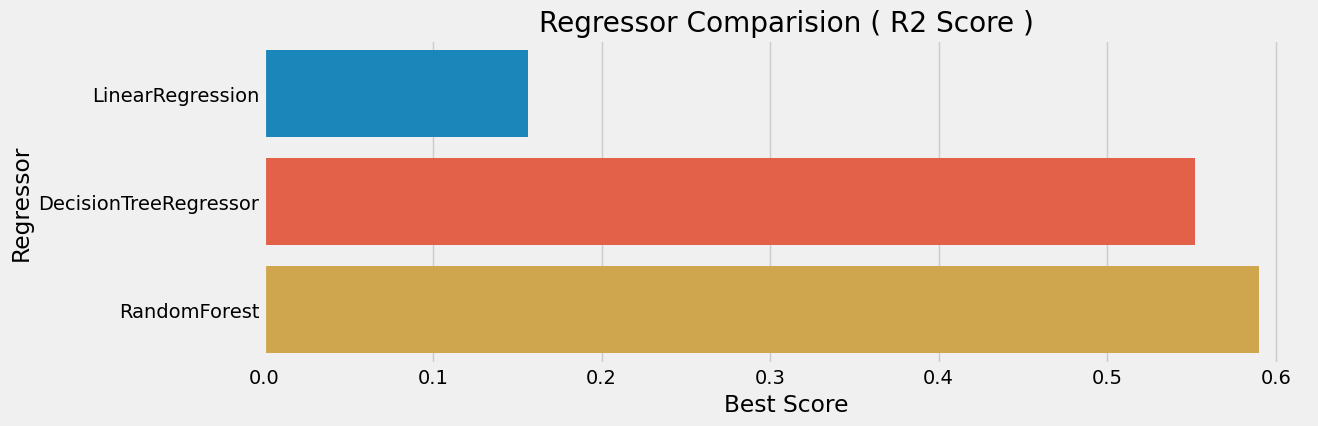

In [61]:
# Summary Repot
summary_cols = ['Best Score']
summary = pd.DataFrame.from_dict(r2_dict, orient = 'index')
summary.index.name = 'Regressor'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizinf results
plt.figure(figsize=(12, 4))
plt.xlabel('Best Score')
plt.title('Regressor Comparision ( R2 Score )')

sns.barplot(x = 'Best Score', y = 'Regressor', data = summary)

# Reference

https://www.kaggle.com/code/slehkyi/e-commerce-predicting-sales